
# Predicting Hospital Readmission within 30 days

## Data Cleaning and Preprocessing

We'll proceed with data preprocessing:
1.   Encoding Categorical Variables: We'll convert categorical variables that are gender, primary_diagnosis, and discharge_to into numerical representations.
2.   Feature Scaling: We’ll standardize numerical features for consistency in model training.



In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score

# Load the dataset
file_path = '/home/train_df.csv'  # Adjust file path if necessary
data = pd.read_csv(file_path)
# Step 2: Encode categorical features
categorical_columns = ['gender', 'primary_diagnosis', 'discharge_to']
label_encoders = {}
for column in categorical_columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le  # Save encoders for potential reverse mapping

# Step 3: Normalize numeric features
scaler = StandardScaler()
numeric_columns = ['age', 'num_procedures', 'days_in_hospital', 'comorbidity_score']
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

# Step 4: Ensure target variable is numeric
data['readmitted'] = data['readmitted'].astype(int)

# Step 5: Split data into features and target
X = data.drop('readmitted', axis=1)
y = data['readmitted']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Step 6: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

The dataset is now preprocessed, with categorical variables converted to numerical form. We have a set of features (X) ready for modeling, and the target variable (y) represents readmission within 30 days.

We will start implementing the following models :

1.   Logistic Regression
2.   Support Vector Machine (SVM)
3.   Decision Trees
4.   Random Forest Classifier



## Logistic regression

Logistic Regression models the probability that a given input belongs to a particular class by applying the sigmoid function to a linear combination of input features.
The sigmoid function squashes the output to a range between 0 and 1, which can then be interpreted as the probability of belonging to the positive class.
We classify an instance as the positive class if the probability exceeds 0.5 (though this threshold can be adjusted).

In [ ]:


# Logistic Regression model implementation from scratch
class LogisticRegression:
    def __init__(self, learning_rate=0.001, iterations=5000):
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.weights = None
        self.bias = None

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.iterations):
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self.sigmoid(linear_model)

            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / n_samples) * np.sum(y_predicted - y)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict_proba(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        return self.sigmoid(linear_model)

    def predict(self, X, threshold=0.5):
        y_predicted = self.predict_proba(X)
        return np.array([1 if i > threshold else 0 for i in y_predicted])

# Train Logistic Regression
log_reg = LogisticRegression(learning_rate=0.001, iterations=5000)
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test.to_numpy())
accuracy_log_reg = np.mean(y_pred_log_reg == y_test.to_numpy())
accuracy_log_reg



0.663

## Gradient boosting

Gradient Boosting is a powerful machine learning algorithm used for both regression and classification tasks. It is based on the concept of building an ensemble of weak learners, typically decision trees, and optimizing their predictions to minimize a specified loss function.

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score

class GradientBoosting:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees = []
        self.initial_prediction = None

    def _initialize(self, y):
        # Initialize with the mean for regression or log-odds for binary classification
        return np.mean(y)

    def _negative_gradient(self, y, y_pred):
        # Compute the residual (negative gradient of MSE loss)
        return y - y_pred

    def _fit_tree(self, X, residuals):
        # Fit a simple regression tree to predict the residuals
        from sklearn.tree import DecisionTreeRegressor
        tree = DecisionTreeRegressor(max_depth=self.max_depth)
        tree.fit(X, residuals)
        return tree

    def fit(self, X, y):
        # Initialize predictions
        self.initial_prediction = self._initialize(y)
        y_pred = np.full(y.shape, self.initial_prediction)

        for _ in range(self.n_estimators):
            # Compute residuals
            residuals = self._negative_gradient(y, y_pred)

            # Fit a tree to the residuals
            tree = self._fit_tree(X, residuals)
            self.trees.append(tree)

            # Update predictions
            y_pred += self.learning_rate * tree.predict(X)

    def predict(self, X):
        # Start with the initial prediction
        y_pred = np.full(X.shape[0], self.initial_prediction)

        # Add contributions from all trees
        for tree in self.trees:
            y_pred += self.learning_rate * tree.predict(X)

        # Convert to binary predictions
        return (y_pred > 0.5).astype(int)

# Instantiate and train the Gradient Boosting model
gb = GradientBoosting(n_estimators=50, learning_rate=0.1, max_depth=3)
gb.fit(X_train, y_train)

# Predict and calculate accuracy
y_pred_gb = gb.predict(X_test)
accuracy_gb = accuracy_score(y_test, y_pred_gb)

# Print the accuracy
print(f"Accuracy of Gradient Boosting: {accuracy_gb:.4f}")



Accuracy of Gradient Boosting: 0.7590


## Decision Trees

A Decision Tree is a non-linear model that splits data based on feature values to separate classes.
Starting from the root, the tree iteratively splits the dataset into branches by choosing the best feature and threshold that minimizes impurity at each step.
Impurity measures how mixed the classes are in a node; in our implementation, we used Gini Impurity, which quantifies the probability of misclassifying a random instance at each node.
At each split, the algorithm selects the feature and threshold that result in the purest child nodes.
The process continues until reaching the maximum depth (defined in our implementation) or if nodes are perfectly pure (contain only one class).

In [ ]:
# Decision Tree model implementation from scratch
class DecisionTree:
    def __init__(self, max_depth=10):
        self.max_depth = max_depth
        self.tree = None

    def _calculate_gini(self, y):
        # Calculate Gini Impurity for a split
        classes = np.unique(y)
        gini = 1.0
        for c in classes:
            p = np.sum(y == c) / len(y)
            gini -= p ** 2
        return gini

    def _split(self, X_column, threshold):
        # Binary split based on threshold
        left_idx = np.where(X_column <= threshold)
        right_idx = np.where(X_column > threshold)
        return left_idx, right_idx

    def _best_split(self, X, y):
        # Find the best split point for data
        best_gini = float('inf')
        best_split = None
        n_features = X.shape[1]

        for feature_idx in range(n_features):
            X_column = X[:, feature_idx]
            thresholds = np.unique(X_column)

            for threshold in thresholds:
                left_idx, right_idx = self._split(X_column, threshold)
                if len(left_idx[0]) == 0 or len(right_idx[0]) == 0:
                    continue

                y_left, y_right = y[left_idx], y[right_idx]
                gini_left, gini_right = self._calculate_gini(y_left), self._calculate_gini(y_right)
                gini = (len(y_left) * gini_left + len(y_right) * gini_right) / len(y)

                if gini < best_gini:
                    best_gini = gini
                    best_split = {"feature_idx": feature_idx, "threshold": threshold, "left_idx": left_idx, "right_idx": right_idx}
        return best_split

    def _build_tree(self, X, y, depth=0):
        # Recursive function to build the decision tree
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        if depth >= self.max_depth or n_labels == 1:
            leaf_value = self._most_common_label(y)
            return {"leaf": True, "value": leaf_value}

        split = self._best_split(X, y)
        if split is None:
            leaf_value = self._most_common_label(y)
            return {"leaf": True, "value": leaf_value}

        left_subtree = self._build_tree(X[split["left_idx"]], y[split["left_idx"]], depth + 1)
        right_subtree = self._build_tree(X[split["right_idx"]], y[split["right_idx"]], depth + 1)

        return {
            "leaf": False,
            "feature_idx": split["feature_idx"],
            "threshold": split["threshold"],
            "left": left_subtree,
            "right": right_subtree,
        }

    def _most_common_label(self, y):
        return np.bincount(y).argmax()

    def fit(self, X, y):
        self.tree = self._build_tree(X, y)

    def _predict(self, inputs, tree):
        if tree["leaf"]:
            return tree["value"]
        feature_value = inputs[tree["feature_idx"]]
        branch = tree["left"] if feature_value <= tree["threshold"] else tree["right"]
        return self._predict(inputs, branch)

    def predict(self, X):
        return np.array([self._predict(x, self.tree) for x in X])

# Instantiate and train the Decision Tree model
dt = DecisionTree(max_depth=10)
dt.fit(X_train.to_numpy(), y_train.to_numpy())

# Predictions and evaluation
y_pred_dt = dt.predict(X_test.to_numpy())
accuracy_dt = np.mean(y_pred_dt == y_test.to_numpy())
accuracy_dt


0.769

## Random Forest Classifier

Random Forest is an ensemble learning method that combines multiple decision trees to improve classification accuracy and generalization.
A Random Forest consists of several decision trees, each trained on a randomly sampled subset of the data (bootstrapping).
Each tree is slightly different because it is trained on a unique subset of the data and often restricted to consider only a random subset of features for each split, making the trees diverse.
To classify a new instance, each tree makes a prediction, and the final prediction is determined by majority voting across all trees.

In [ ]:
import random

# Random Forest Classifier model implementation from scratch
class RandomForest:
    def __init__(self, n_trees=10, max_depth=10, sample_size=0.8):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.sample_size = sample_size
        self.trees = []

    def _bootstrap_sample(self, X, y):
        # Randomly sample data with replacement
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, int(n_samples * self.sample_size), replace=True)
        return X[indices], y[indices]

    def fit(self, X, y):
        # Train multiple decision trees
        for _ in range(self.n_trees):
            tree = DecisionTree(max_depth=self.max_depth)
            X_sample, y_sample = self._bootstrap_sample(X, y)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        # Aggregate predictions from each tree
        tree_predictions = np.array([tree.predict(X) for tree in self.trees])
        # Majority vote
        return np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=tree_predictions)

# Instantiate and train the Random Forest model
rf = RandomForest(n_trees=10, max_depth=10, sample_size=0.8)
rf.fit(X_train.to_numpy(), y_train.to_numpy())

# Predictions and evaluation
y_pred_rf = rf.predict(X_test.to_numpy())
accuracy_rf = np.mean(y_pred_rf == y_test.to_numpy())
accuracy_rf


0.806

## Neural Network

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

class NeuralNetworkModel:
    def __init__(self, input_shape):
        self.model = Sequential([
            Dense(64, activation='relu', input_shape=(input_shape,)),
            Dense(32, activation='relu'),
            Dense(32, activation='relu'),
            Dense(1, activation='sigmoid')
        ])

    def compile_model(self, optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']):
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    def train_model(self, X_train, y_train, X_val, y_val, epochs=40, batch_size=32):
        history = self.model.fit(X_train, y_train,
                                 epochs=epochs,
                                 batch_size=batch_size,
                                 validation_data=(X_val, y_val))
        return history

    def evaluate_model(self, X_test, y_test):
        loss, accuracy = self.model.evaluate(X_test, y_test)
        print(f"Test accuracy: {accuracy}")
        return loss, accuracy

    def predict(self, X):
        predictions = self.model.predict(X)
        predicted_classes = (predictions > 0.5).astype(int)
        return  np.array(predicted_classes)


binary_model = NeuralNetworkModel(input_shape=X_train.shape[1])
binary_model.compile_model()
history = binary_model.train_model(X_train, y_train, X_test, y_test)
loss, accuracy = binary_model.evaluate_model(X_test, y_test)
predicted_classes = binary_model.predict(X_test)


Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5310 - loss: 0.6905 - val_accuracy: 0.4840 - val_loss: 0.6976
Epoch 2/40
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5829 - loss: 0.6779 - val_accuracy: 0.6130 - val_loss: 0.6635
Epoch 3/40
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5986 - loss: 0.6736 - val_accuracy: 0.6240 - val_loss: 0.6517
Epoch 4/40
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6043 - loss: 0.6619 - val_accuracy: 0.5390 - val_loss: 0.6952
Epoch 5/40
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6254 - loss: 0.6536 - val_accuracy: 0.6180 - val_loss: 0.6508
Epoch 6/40
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6221 - loss: 0.6475 - val_accuracy: 0.5770 - val_loss: 0.6747
Epoch 7/40
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6497 - loss: 0.6371 - val_accuracy: 0.5930 - val_loss: 0.6728
Epoch 8/40
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6482 - loss: 0.6239 - val_accuracy: 0.5960 - val_

## Evaluating Model Performance

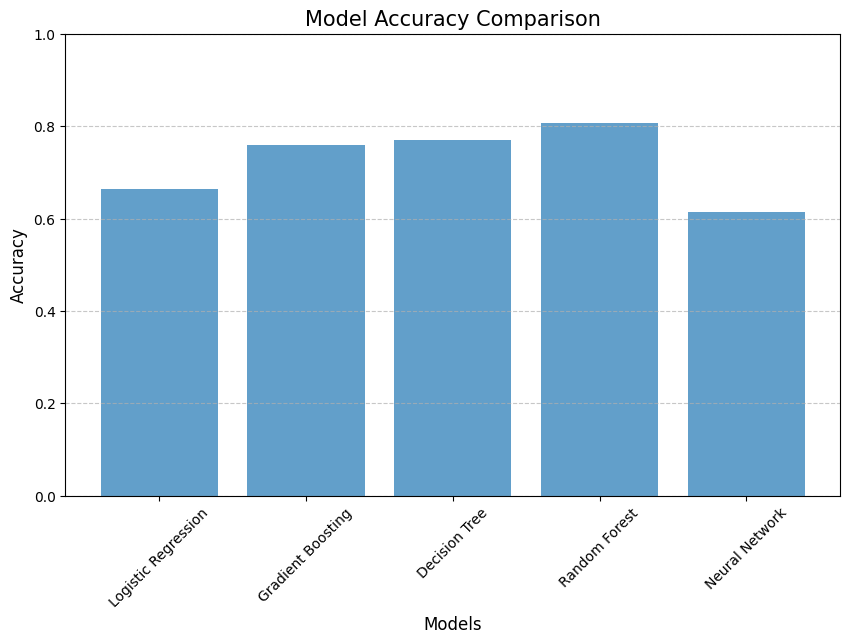

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have accuracy values for each model
model_accuracies = {
    "Logistic Regression": accuracy_log_reg,  # Replace with actual accuracy
    "Gradient Boosting": accuracy_gb,                 # Replace with actual accuracy
    "Decision Tree": accuracy_dt,       # Replace with actual accuracy
    "Random Forest": accuracy_rf,       # Replace with actual accuracy
    "Neural Network": 0.614       # Replace with actual accuracy
}

# Extract model names and their accuracies
models = list(model_accuracies.keys())
accuracies = list(model_accuracies.values())

# Plot the bar graph
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, alpha=0.7)
plt.xlabel("Models", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Model Accuracy Comparison", fontsize=15)
plt.ylim(0, 1)  # Accuracy range [0, 1]
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

## Plotting the Decision Boundaries


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does

121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


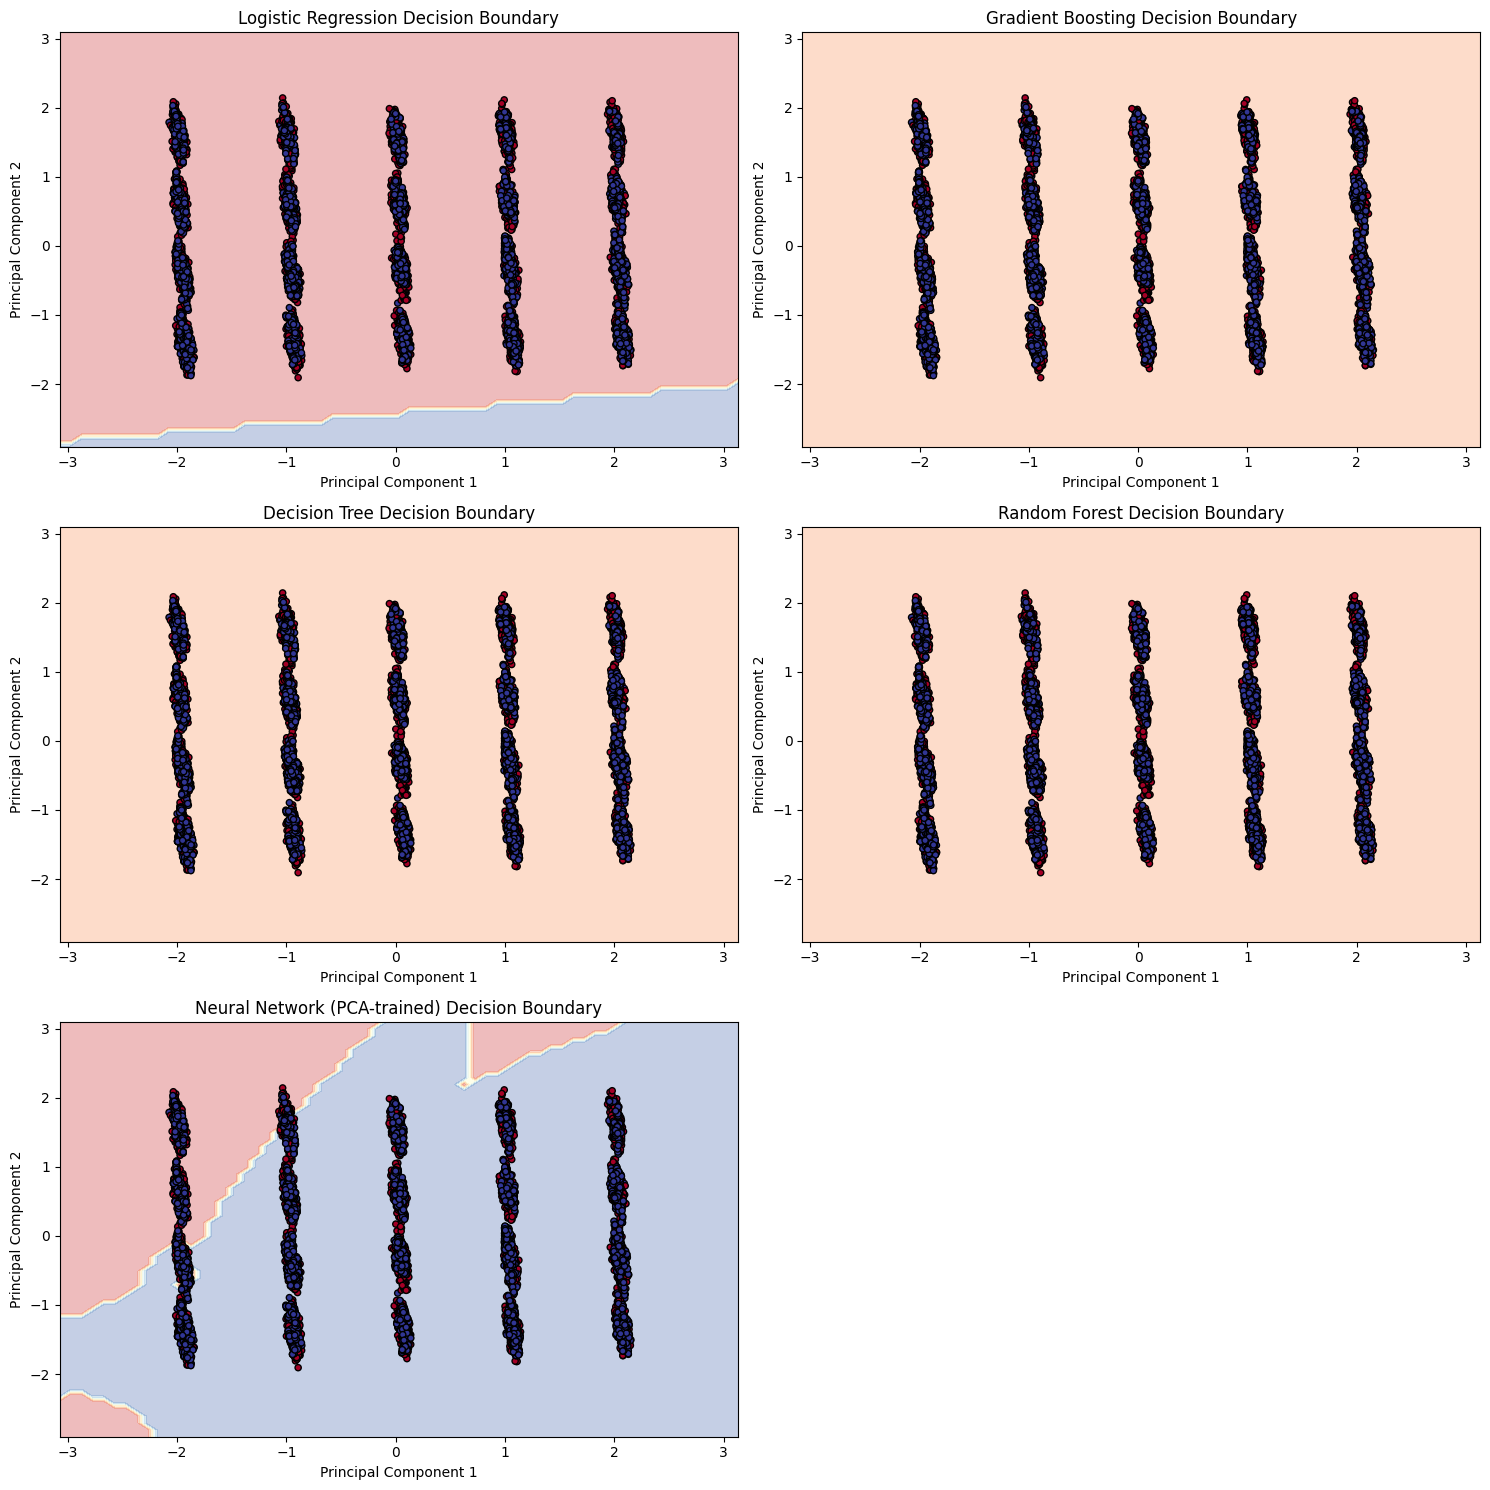

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Step 1: Apply PCA to reduce to 2D for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)  # Apply PCA to test data for consistency

# Step 2: Create a mesh grid in PCA space
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
grid = np.c_[xx.ravel(), yy.ravel()]

# Transform grid back to original feature space
grid_original_space = scaler.inverse_transform(pca.inverse_transform(grid))

# List of pre-trained models and titles
models = [
    (log_reg, "Logistic Regression"),
    (gb, "Gradient Boosting"),
    (dt, "Decision Tree"),
    (rf, "Random Forest"),
    (binary_model, "Neural Network (PCA-trained)")
]

# Plotting function
def plot_decision_boundary(model, grid_original_space, xx, yy, title):
    try:
        if hasattr(model, "predict"):
            Z = model.predict(grid_original_space)
        elif isinstance(model, NeuralNetworkModel):
            Z = model.predict(pca.transform(grid)).ravel()  # Neural network predictions
            Z = (Z > 0.5).astype(int)
        else:
            raise ValueError(f"Unsupported model for plotting: {title}")

        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdYlBu)
        plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, edgecolor="k", s=20, marker="o", cmap=plt.cm.RdYlBu)
        plt.xlabel("Principal Component 1")
        plt.ylabel("Principal Component 2")
        plt.title(title)

    except Exception as e:
        print(f"Error plotting {title}: {e}")

# Plot decision boundaries
plt.figure(figsize=(15, 15))
for i, (model, title) in enumerate(models, 1):
    plt.subplot(3, 2, i)
    plot_decision_boundary(model, grid_original_space, xx, yy, f"{title} Decision Boundary")

plt.tight_layout()
plt.show()
